In [1]:
%matplotlib widget

import numpy as np
import plotly.graph_objects as go
import magpylib as magpy
from numpy import genfromtxt
import numpy as np
from scipy.spatial.transform import Rotation as R
import magpylib as magpy
import matplotlib.pyplot as plt
from scipy.optimize import root
import numpy as np
from scipy.signal import butter, lfilter, freqz, detrend
import matplotlib.pyplot as plt
import scipy.fftpack

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

fs = 1/0.01      # sample rate, Hz

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)
def butter_highpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='high', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

## IMPORT DATA
def load_data(filename):
    my_data = genfromtxt(filename, delimiter=',')
    my_data = my_data[1:]
    b_abs = [reading[4] for reading in my_data]
    time = [reading[0] for reading in my_data]
    return time, b_abs

# calculate B-field return uT
def calc_b_field(magnet, sensor, distance):
    distance = abs(distance)
    # disp = np.linspace((0,0,0), (0, 0, distance), 100)
    magnet.position=(0, 0, 0)
    magnet.move((0, 0, distance))

    B = sensor.getB(magnet)
    B_mag = [np.linalg.norm(B_coord) for B_coord in B]
    return B_mag[-1] * 1000

def calc_b_field_vec(magnet, sensor, distances):
    b_mag_vector = []
    for distance in distances:
        magnet.position=(0, 0, 0)
        magnet.move((0, 0, distance))

        B = sensor.getB(magnet)
        B_mag = [np.linalg.norm(B_coord) for B_coord in B]
        b_mag_vector.append(B_mag[-1] * 1000)
    return b_mag_vector

# caculate distance given uT return mm
@np.vectorize
def calc_displacement(magnet, sensor, MagReading):
    def f(distance):
        return calc_b_field(magnet, sensor, distance) - MagReading
    r = root(f, 0, tol=0.1)
    return r.x[0]

def calc_signal_stats(signal):
    noise_std_dev = np.std(signal)
    noise_min = np.min(signal)
    noise_max = np.max(signal)
    noise_delta = noise_max - noise_min
    print("Min: ", noise_min)
    print("Max: ", noise_max)
    print("Average: ", avg)
    print("Standard Deviation: ", noise_std_dev)
    print("Delta:", noise_delta)

100.0


/Users/pvelesko/Library/Python/3.8/lib/python/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/pvelesko/Library/Python/3.8/lib/python/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


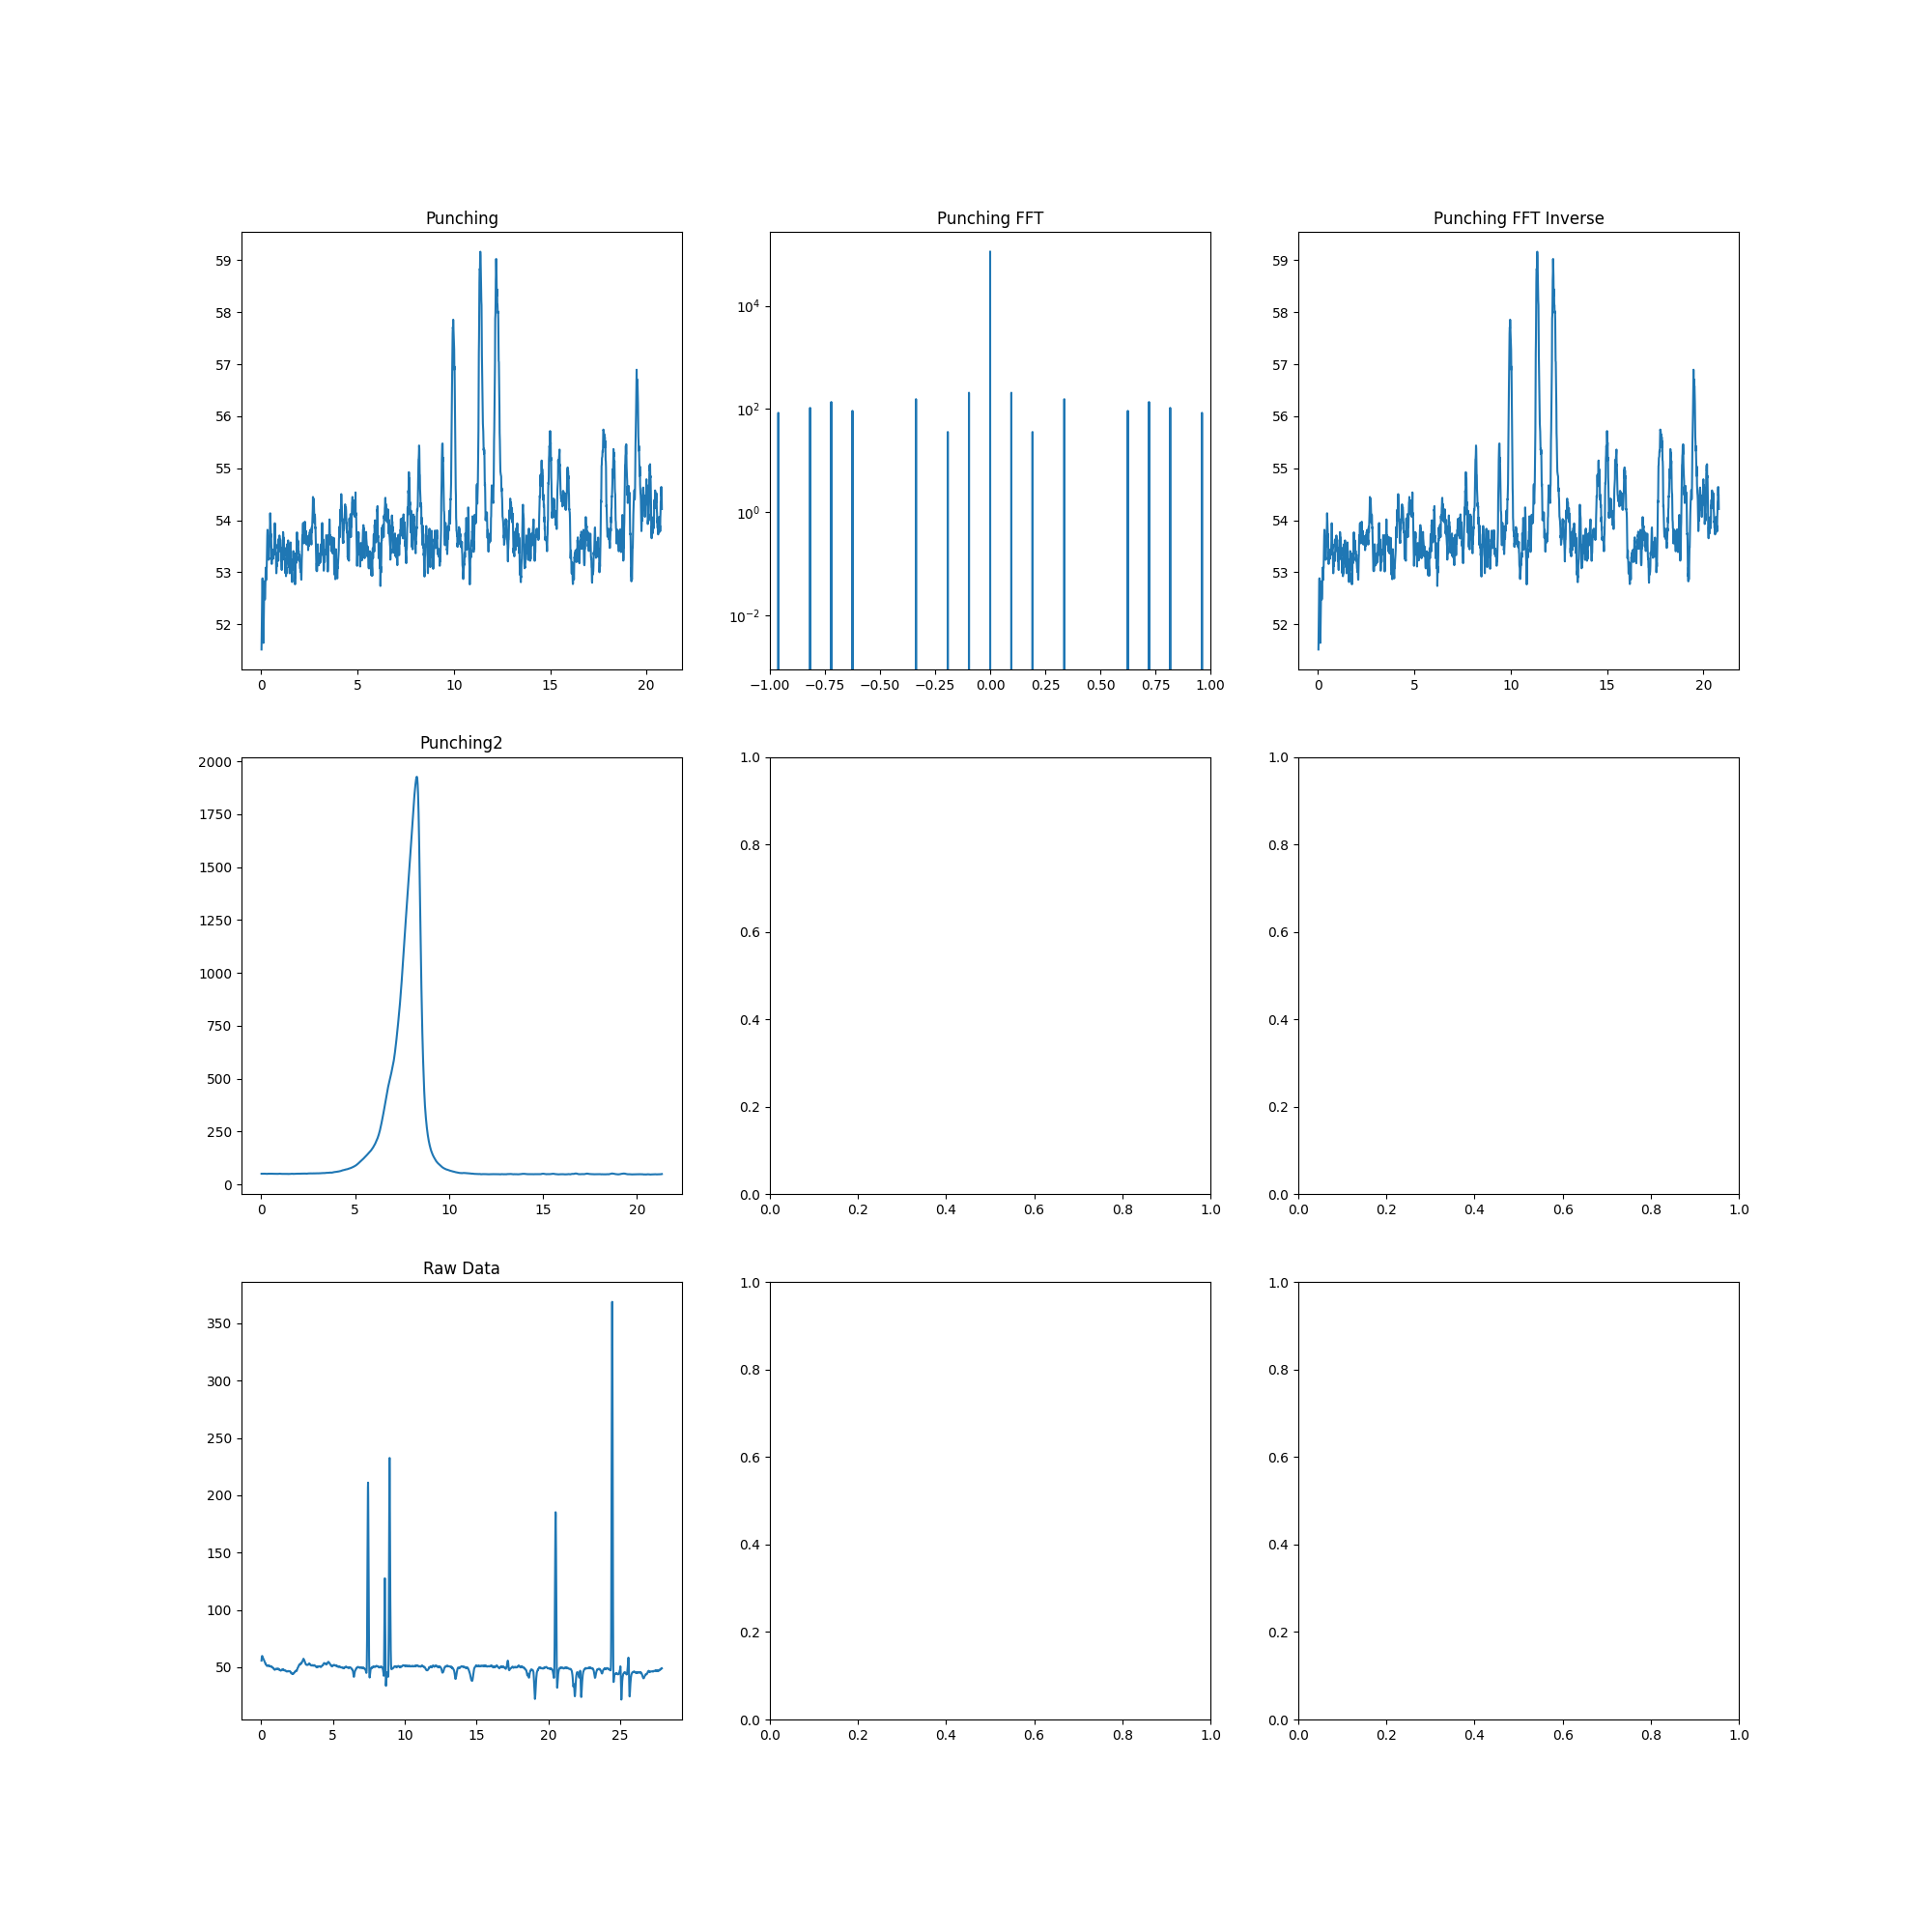

In [13]:
# plt.switch_backend("macosx")
%matplotlib widget
fig = plt.figure(figsize=(20, 20))
ax = fig.subplots(3,3)
print(fs)
t_punching, b_punching = load_data('punching.csv')
b_punching_fft = np.fft.fft(b_punching)
b_punching_freq = np.fft.fftfreq(len(b_punching), 1/fs)

ax[0][0].plot(t_punching, b_punching)
ax[0][0].set_title('Punching')

ax[0][1].semilogy(b_punching_freq, b_punching_fft)
ax[0][1].set_title('Punching FFT')
ax[0][1].set_xlim(-1, 1)

b_punching_fft_inv = np.fft.ifft(b_punching_fft)
b_punching_freq = np.fft.fftfreq(len(b_punching), 1/fs)

ax[0][2].plot(t_punching, b_punching_fft_inv)
ax[0][2].set_title('Punching FFT Inverse')
# ax[0][2].set_xlim(-1, 1)



t_punching2, b_punching2 = load_data('punching2.csv')
ax[1][0].plot(t_punching2, b_punching2)
ax[1][0].set_title('Punching2')

t_raw, b_raw = load_data('raw_data.csv')
ax[2][0].plot(t_raw, b_raw)
ax[2][0].set_title('Raw Data')

plt.show()



/Users/pvelesko/Library/Python/3.8/lib/python/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


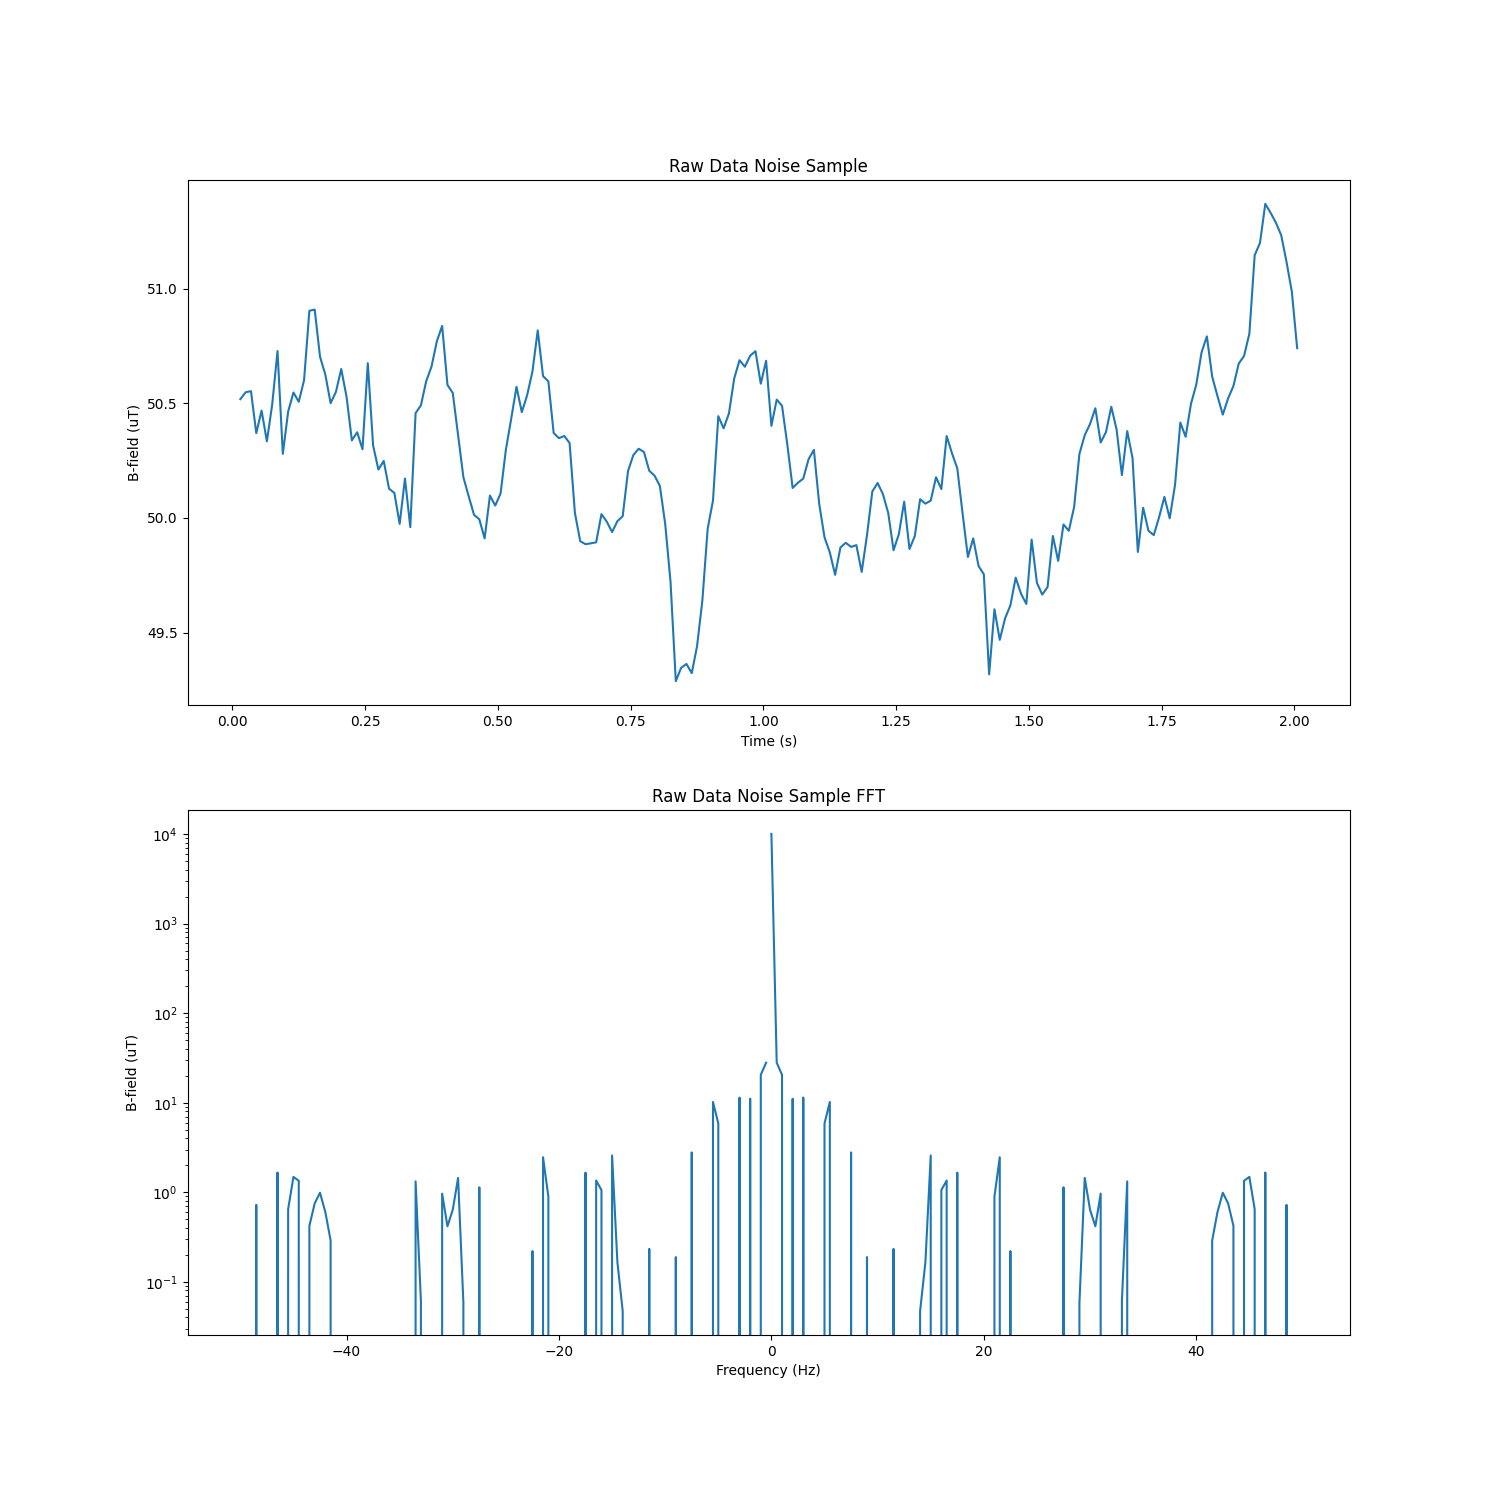

In [3]:
# CALCULATE NOISE
t_noise = t_punching2
b_noise = b_punching2
num_samples = 200
t_noise = t_noise[:num_samples]
b_noise = b_noise[:num_samples]
fig = plt.figure(figsize=(15, 15))
ax = fig.subplots(2)
b_noise_fft = np.fft.fft(b_noise)
b_noise_freq = np.fft.fftfreq(len(b_noise), 1/fs)
b_noise_fft_inv = np.fft.ifft(b_noise_fft)

ax[0].plot(t_noise, b_noise)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("B-field (uT)")
ax[0].set_title("Raw Data Noise Sample")

ax[1].semilogy(b_noise_freq, b_noise_fft)
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("B-field (uT)")
ax[1].set_title("Raw Data Noise Sample FFT")

noise_avg = np.average(b_noise)
# calc_signal_stats(t_noise)




In [4]:
# DEFINE MAGNET
noise_delta = 2
max_reading = 800 # uT max reading from magnetometer
n52_magnetization = 1420# mT
min_reading = 3 * noise_delta # uT min reading from magnetometer should - should be some function of noise floor

# I need to define a magnet such that the max reading of 800uT is ~10 cm (elbows together)
magnet = magpy.magnet.Cuboid(
    magnetization=(0,0, n52_magnetization),
    dimension=(40,10,8),
    position=(0,0,0),
)

sens = magpy.Sensor(
    position=(0,0,0),
    pixel=[(0,0,0)],
    style_pixel_size=0.5,
    style_size=1.5,
)

In [5]:
# FIND CALIBRATION DISTANCE
def calc_calibration_distance(max_b_reading):
    def f(d):
        err = abs(max_b_reading - calc_b_field(magnet, sens, d))
        return err
    r = root(f, 50, tol=0.01)
    # print(r)
    return r.x[0]

calibration_distance = calc_calibration_distance(max_reading)
print("Calibration distance: %d mm" % calibration_distance)

# FIND MAX DISTANCE
def calc_max_distance(min_b_reading):
    def f(d):
        err = abs(min_b_reading - calc_b_field(magnet, sens, d))
        return err
    r = root(f, 0, tol=0.01)
    # print(r)
    return abs(r.x[0])

max_distance = calc_max_distance(min_reading)
print("Max distance: %d mm" % max_distance)

Calibration distance: 95 mm
Max distance: 493 mm


(95.33831154107764, 500.0)

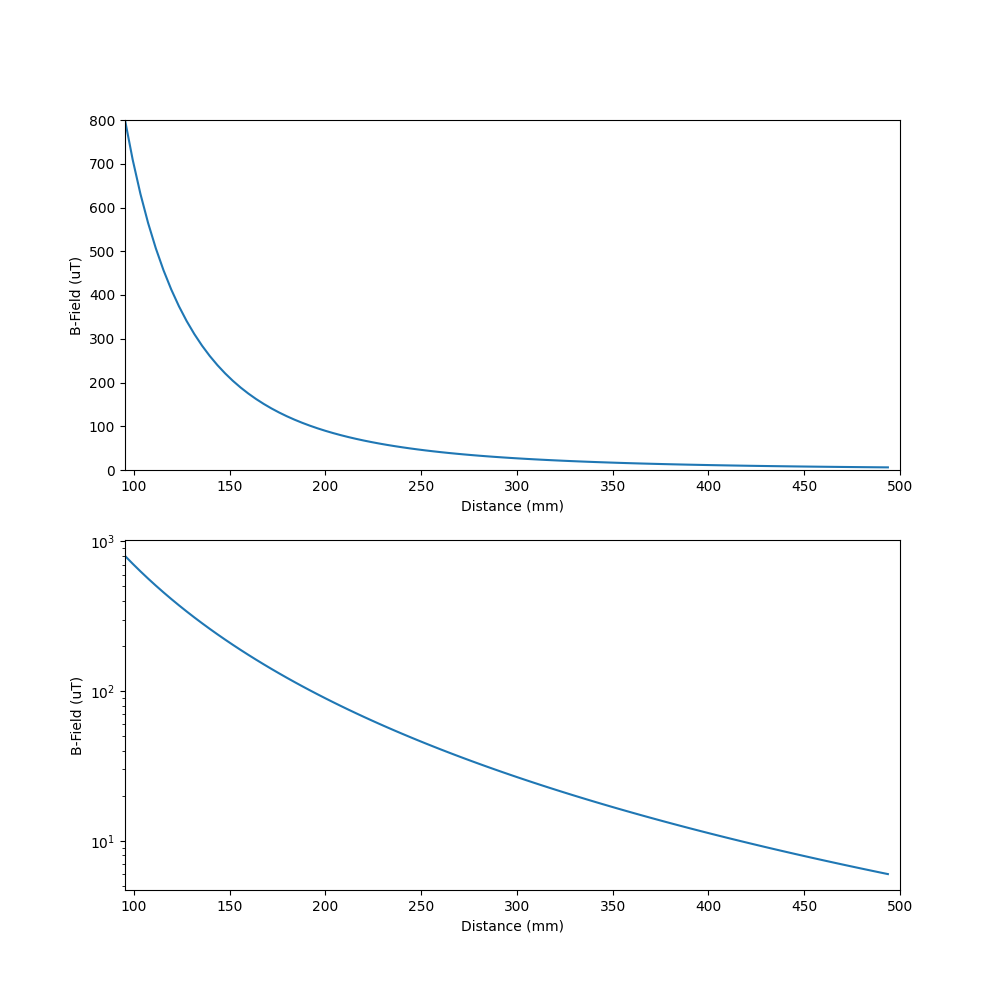

In [6]:
# Calc B-field for each distance
# Test at 5cm - 50cm
d = np.linspace(calibration_distance, max_distance, 100)
B = [calc_b_field(magnet, sens, distance) for distance in d]

fig = plt.figure(figsize=(10, 10))
ax = fig.subplots(2)
ax[0].plot(d, B)
ax[0].set_ylabel("B-Field (uT)")
ax[0].set_xlabel("Distance (mm)")
ax[0].set_xlim(calibration_distance, 500)
ax[0].set_ylim(0, max_reading)
ax[1].semilogy(d, B)
ax[1].set_ylabel("B-Field (uT)")
ax[1].set_xlabel("Distance (mm)")
ax[1].set_xlim(calibration_distance, 500)


In [7]:
# ## 3D SIMULATE
# print(calcBField(50)*1000)
# print(calcDisplacement(1))

# # shaft rotation / magnet wobble motion
# displacement = 1
# angles = np.linspace(0, 360, 72)
# coll = magnet
# magnet.move((displacement, 0, 0))
# coll.rotate_from_angax(angles, 'z', anchor=0, start=0)

# # show 3D animation of wobble motion
# fig1 = go.Figure()
# magpy.show(magnet, sens, animation=True, backend='plotly', canvas=fig1)
# fig1.update_layout(scene_camera_eye_z=-1.1)
# fig1.show()

# # show sensor output in plotly
# fig2 = go.Figure()
# B = sens.getB(magnet)
# for px,dash in zip([0,1], ['solid', 'dash']):
#     for i,xy,col in zip([0,1], ['x','y'], ['red', 'green']):
#         fig2.add_trace(go.Scatter(x=angles, y=B[:,px,i],
#             name=f"pixel{px}-B{xy}",
#             line=dict(color=col, dash=dash),
#         ))
# fig2.update_layout(
#     xaxis_title='angle [deg]',
#     yaxis_title='field [mT]'
# )
# fig2.show()



In [8]:
# disp = np.linspace((0,0,0), (0, 0, 33.33), 101)
# magnet.move(disp, start=-1)

# fig1 = go.Figure()
# magpy.show(magnet, sens, animation=True, backend='plotly', canvas=fig1)
# fig1.show()



# B = sens.getB(magnet)

# b_mag = [np.linalg.norm(B_coord) for B_coord in B]
# disp_mag = [int(np.linalg.norm(d)) for d in disp] 
# fig = plt.figure()
# ax = fig.subplots()
# ax.plot(disp_mag, b_mag, "r")
# ax.set_xlabel("displacement (mm)")
# ax.set_ylabel("Field (uT)")



Text(0, 0.5, 'Displacement Error (mm)')

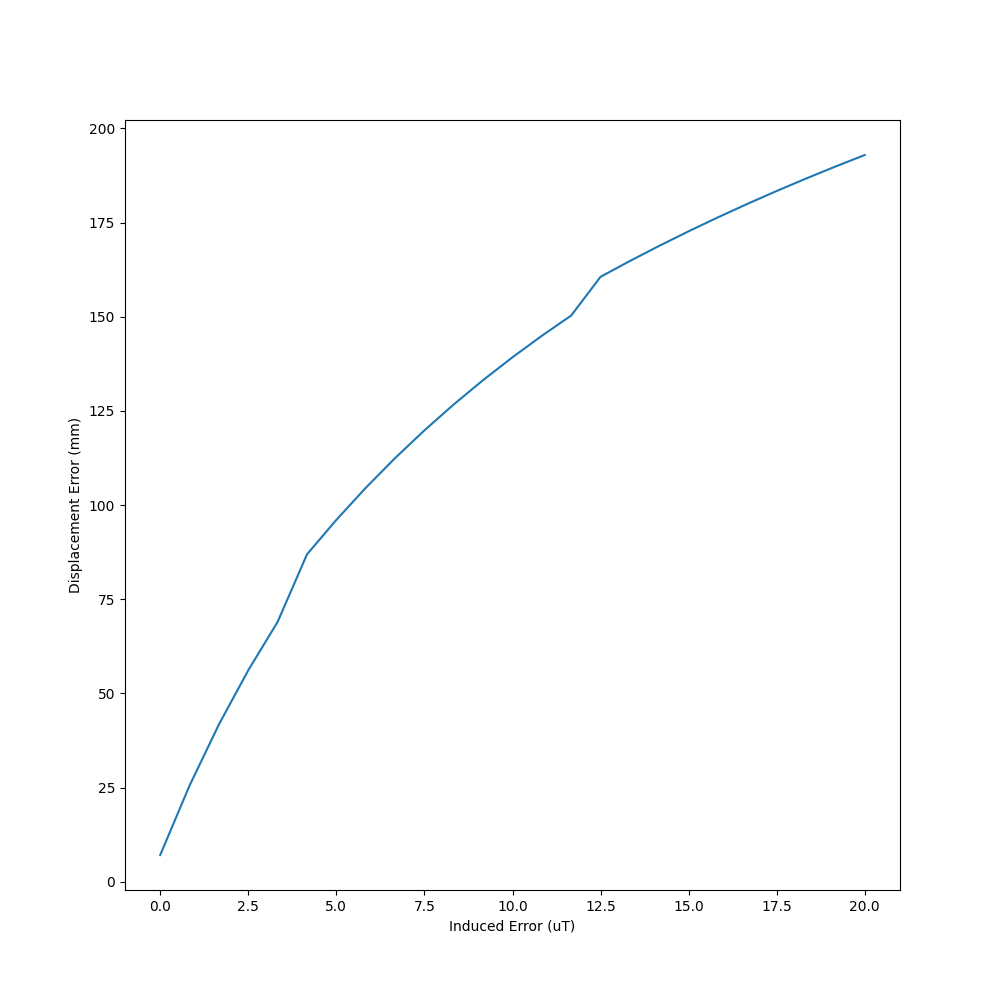

In [9]:
# ESTIME ERROR AT DISTANCE
@np.vectorize
def calc_error(reading_distance, induced_error):
    b_true = abs(calc_b_field(magnet, sens, reading_distance))
    d_true = abs(reading_distance)

    err = d_true - abs(calc_displacement(magnet, sens, b_true + induced_error))
    err = np.abs(err)
    return err

induced_error = np.linspace(0, 10*noise_delta, 25) # Error range from 0 to 2uT
reading_distance = np.linspace(calibration_distance, max_distance, 10)
X, Y = np.meshgrid(reading_distance, induced_error)
Z = calc_error(X, Y)

err = calc_error(max_distance, induced_error)
fig = plt.figure(figsize=(10, 10))
ax = fig.subplots()
ax.plot(induced_error, err)
ax.set_xlabel("Induced Error (uT)")
ax.set_ylabel("Displacement Error (mm)")

Text(0, 0.5, 'Displacement Error (mm)')

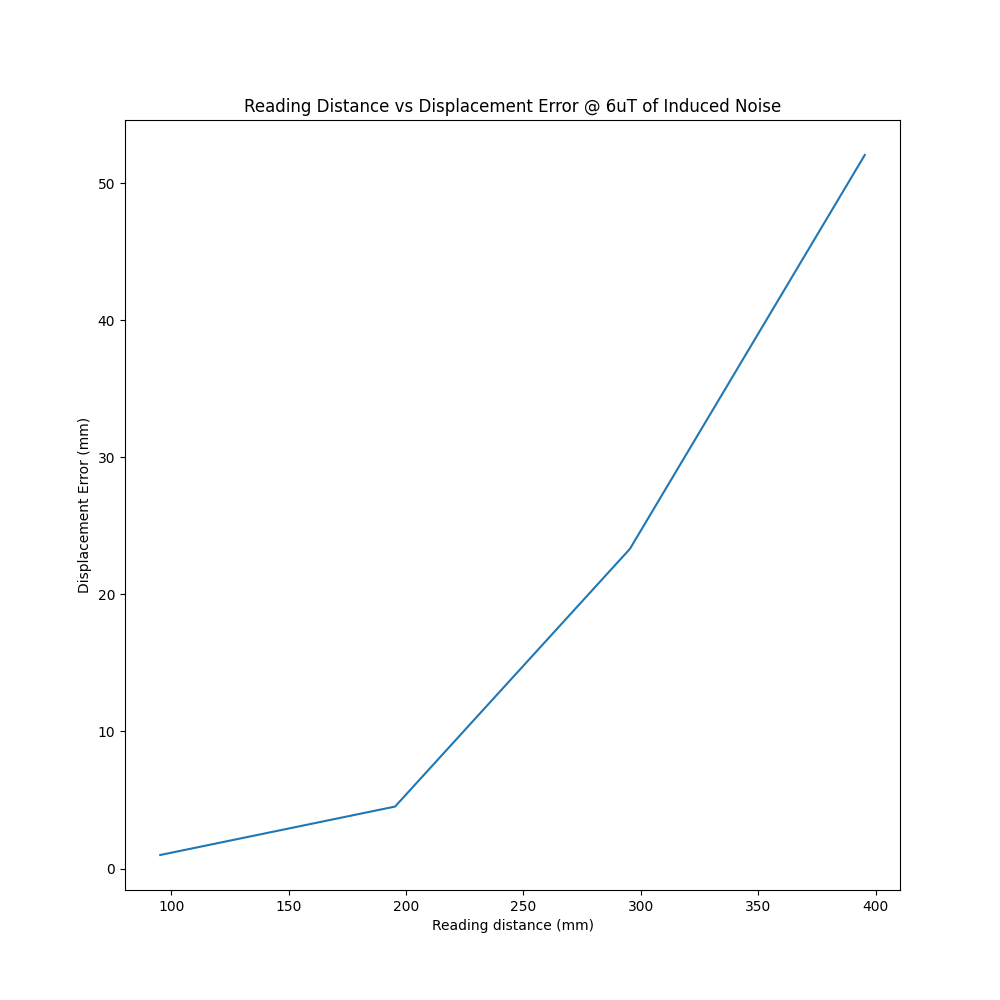

In [10]:
distance = np.arange(calibration_distance, max_distance, 100)
err = calc_error(distance, 6)
fig = plt.figure(figsize=(10, 10))
ax = fig.subplots()
ax.plot(distance, err)
ax.set_title("Reading Distance vs Displacement Error @ 6uT of Induced Noise")
ax.set_xlabel("Reading distance (mm)")
ax.set_ylabel("Displacement Error (mm)")

In [14]:
fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z)])

fig.update_layout(title='Error', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()
calc_error(11, 486)


array(0.01521488)

Min:  49.28771683
Max:  51.37125948
Average:  50.25043923975
Standard Deviation:  0.39754652319885203
Delta: 2.0835426499999983

b_noise signal stats:
Min:  49.28771683
Max:  51.37125948
Average:  50.25043923975
Standard Deviation:  0.39754652319885203
Delta: 2.0835426499999983

b_noise_filtered signal stats:
Min:  49.44874562554618
Max:  51.365871379669045
Average:  50.25043923975
Standard Deviation:  0.43128110154397
Delta: 1.9171257541228641


/Users/pvelesko/Library/Python/3.8/lib/python/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part

/Users/pvelesko/Library/Python/3.8/lib/python/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



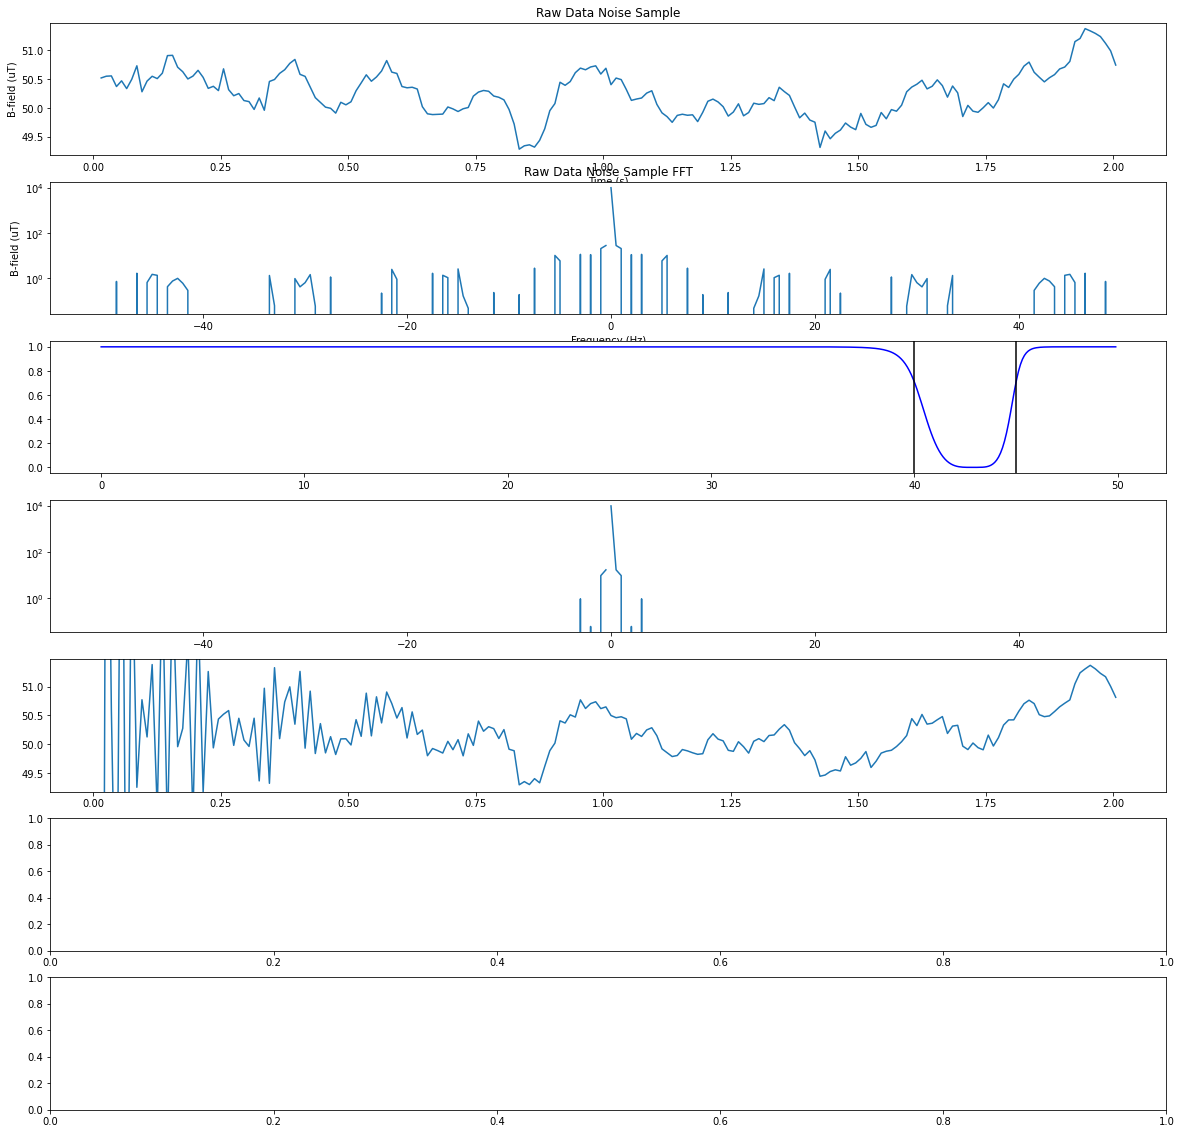

In [ ]:
## HIGH PASS FILTER


# Filter requirements.
order = 4
cutoff_lowpass = 40
cutoff_highpass = 45

fig = plt.figure(figsize=(20, 20))
ax = fig.subplots(7)

ax[0].plot(t_noise, b_noise)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("B-field (uT)")
ax[0].set_title("Raw Data Noise Sample")

ax[1].semilogy(b_noise_freq, b_noise_fft)
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("B-field (uT)")
ax[1].set_title("Raw Data Noise Sample FFT")
# print(np.arange(b_noise_freq[0], b_noise_freq[-1], 2))
# ax[1].set_xticks()

avg = np.mean(b_noise)
noise_std_dev = np.std(b_noise)
noise_min = np.min(b_noise)
noise_max = np.max(b_noise)
noise_delta = noise_max - noise_min
print("Min: ", noise_min)
print("Max: ", noise_max)
print("Average: ", avg)
print("Standard Deviation: ", noise_std_dev)
print("Delta:", noise_delta)

# # Get the filter coefficients so we can check its frequency response.
b, a = butter(order, [cutoff_lowpass, cutoff_highpass], fs=fs, btype='bandstop', analog=False)
b_noise_filtered = lfilter(b, a, b_noise)

# # Plot the frequency response.
w, h = freqz(b, a, fs=fs)
ax[2].plot(w, np.abs(h), 'b')
ax[2].axvline([cutoff_lowpass], color='k')
ax[2].axvline([cutoff_highpass], color='k')
# ax[2].xlim(0, 0.5*fs)
# ax[2].title("Lowpass Filter Frequency Response")
# ax[2].xlabel('Frequency [Hz]')
# ax[2].grid()
ax[3].semilogy(b_noise_freq, (np.fft.fft(b_noise_filtered)))
ax[4].plot(t_noise, b_noise_filtered)
ax[4].set_ylim(ax[0].get_ylim())

print("\nb_noise signal stats:")
calc_signal_stats(b_noise)
print("\nb_noise_filtered signal stats:")
calc_signal_stats(b_noise_filtered[int(len(b_noise_filtered)/2):])


# # Filter the data, and plot both the original and filtered signals.
# # filtered = butter_lowpass_filter(data, cutoff, fs, order)
# # filtered = butter_highpass_filter(filtered, , fs, order)

# filtered = data
# scipy.signal.detrend(filtered, axis=- 1, type='constant', bp=0, overwrite_data=True)


# # # remove outliers
# # for x in range(len(filtered)):
# #     if abs(filtered[x] - avg) > 1*std_dev:
# #         filtered[x] = avg


# fig = plt.figure()
# axes = fig.subplots(3)

# axes[0].plot(t_noise, data, 'b-', linewidth=1, label='data')
# axes[0].set_xlabel('Time [sec]')
# axes[0].grid()
# axes[0].ticklabel_format(useOffset=False)
# # axes[0].set_ylim(45, 48)
# # plt.legend()

# fig.subplots_adjust(hspace=0.35)
# axes[1].plot(t_noise, filtered, 'g-', linewidth=1, label='filtered data')
# axes[1].set_xlabel('Time [sec]')
# axes[1].grid()
# # axes[1].set_xlim(0, 5)
# # axes[1].set_ylim(45, 48)

# plt.show()

# import scipy.fftpack
# yf = scipy.fftpack.rfft(filtered)

# # Number of samplepoints
# SAMPLE_RATE = 1/0.01 
# N = len(filtered)
# # sample spacing
# T = 1.0 / 800.0

# xf = scipy.fftpack.fftfreq(N, 1 / SAMPLE_RATE)
# fig, ax = plt.subplots()
# ax.semilogy(xf, yf)
# # ax.set_xlim(-1, 10)
# # ax.set_ylim(0,  10e6)
# # print(filtered)

# filtered_avg = np.average(filtered)
# for x in range(len(filtered)):
#     if filtered[x] > filtered_avg:
#         print("Delay = ", time[x])
#         break

# dist = [calc_displacement(x) for x in filtered]
# axes[2].plot(t_noise, dist, 'g-', linewidth=1, label='filtered data')


/Users/pvelesko/Library/Python/3.8/lib/python/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part

/Users/pvelesko/Library/Python/3.8/lib/python/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



Min:  51.51464763
Max:  59.1652143
Average:  50.25043923975
Standard Deviation:  0.9323264938910494
Delta: 7.6505666700000035
Min:  34.10351257897226
Max:  59.50270092155547
Average:  50.25043923975
Standard Deviation:  1.0670675999337675
Delta: 25.399188342583216


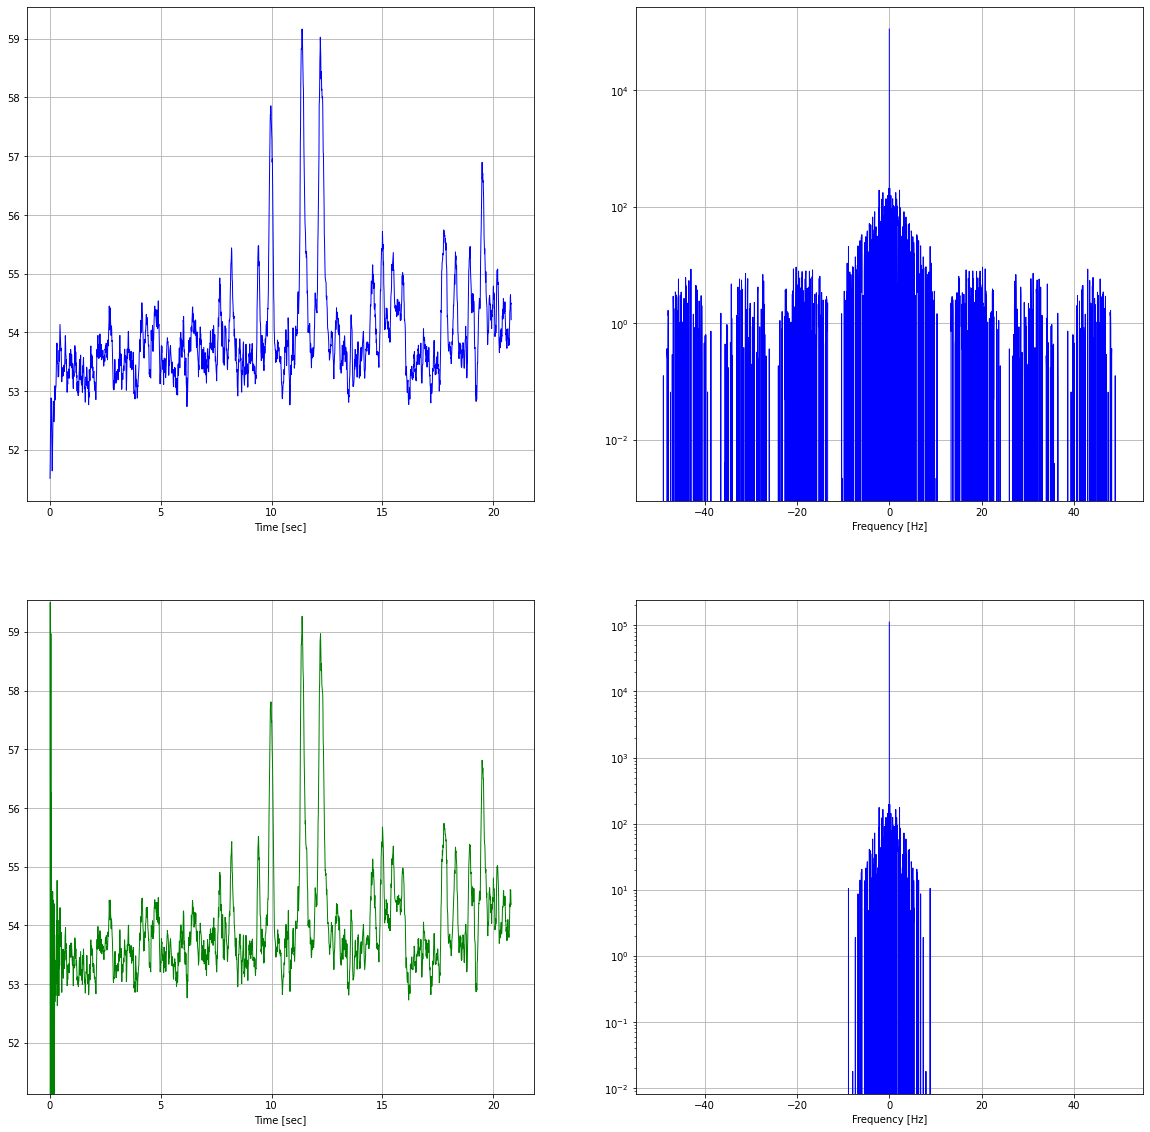

In [ ]:

def plot_signal_filtered(x, y, b, a):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.subplots(2, 2)
    yf = lfilter(b, a, y)
    y_fft = np.fft.fft(y)
    y_fft_freq = np.fft.fftfreq(len(y), 1 / fs)
    yf_fft = np.fft.fft(yf)

    ax[0][0].plot(x, y, 'b-', linewidth=1, label='data')
    ax[0][0].set_xlabel('Time [sec]')
    ax[0][0].grid()
    ax[0][1].semilogy(y_fft_freq, y_fft, 'b-', linewidth=1, label='data')
    ax[0][1].set_xlabel('Frequency [Hz]')
    ax[0][1].grid() 

    ax[1][0].plot(x, yf, 'g-', linewidth=1, label='filtered data')
    ax[1][0].set_xlabel('Time [sec]')
    ax[1][0].grid()
    ax[1][0].set_ylim(ax[0][0].get_ylim())
    ax[1][1].semilogy(y_fft_freq, yf_fft, 'b-', linewidth=1, label='data')
    ax[1][1].set_xlabel('Frequency [Hz]')
    ax[1][1].grid() 
    # ax[x].ticklabel_format(useOffset=False)
    calc_signal_stats(y)
    calc_signal_stats(yf)

plot_signal_filtered(t_punching, b_punching, b, a)


In [ ]:

disp_punching = calc_displacement(magnet, sens, b_punching)



In [ ]:
data = b_raw
disp_zero = calc_displacement(magnet, sens, noise_avg)
data_filtered = np.abs(calc_displacement(magnet, sens, data)) - disp_zero


(363.67212712526907, 559.4355937487617)

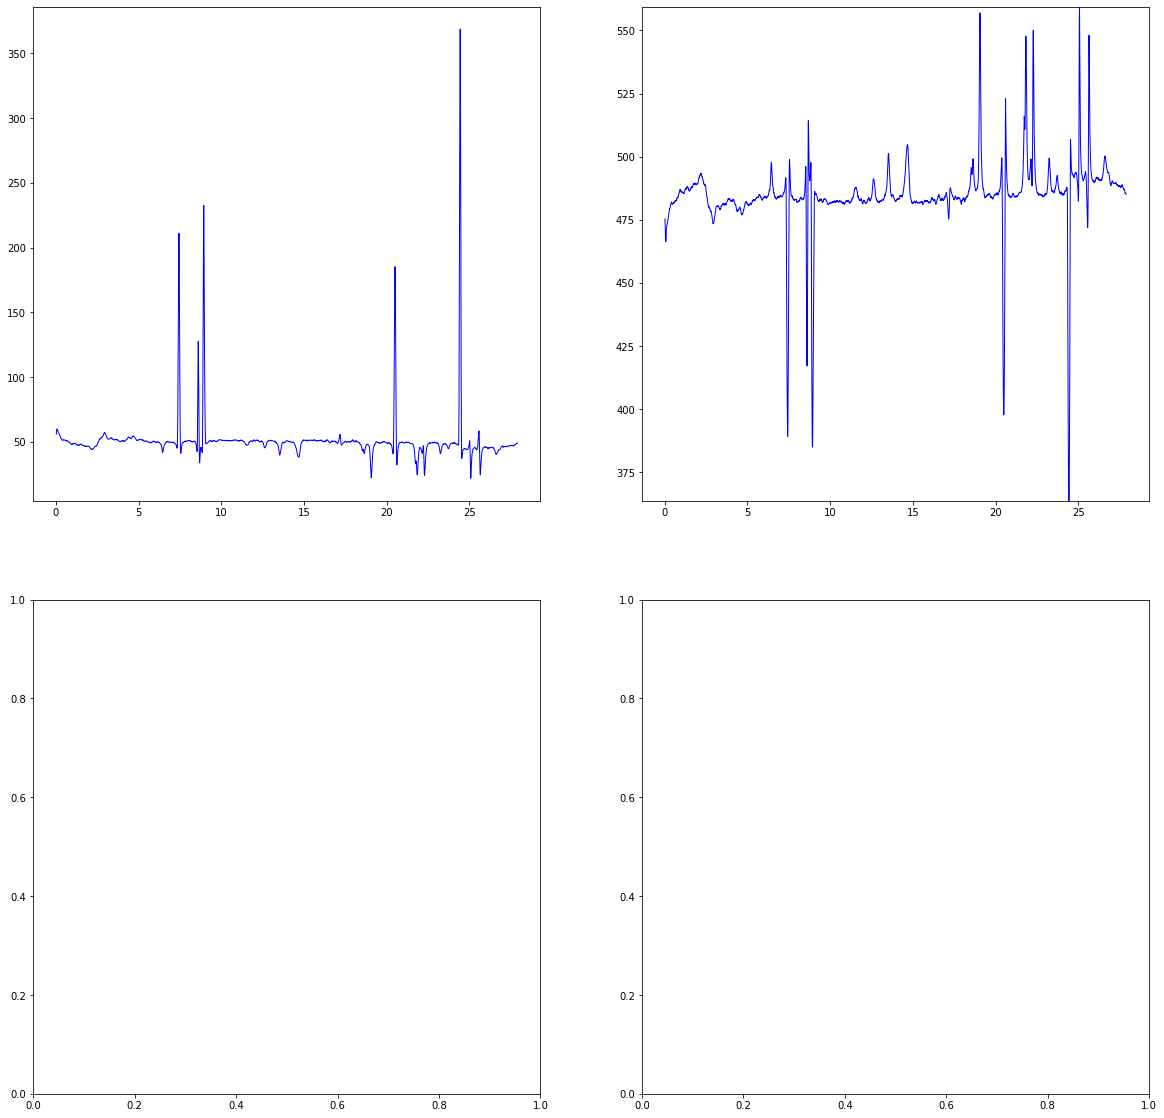

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = fig.subplots(2, 2)
ax[0][0].plot(t_raw, data, 'b-', linewidth=1, label='data')
ax[0][1].plot(t_raw, data_filtered, 'b-', linewidth=1, label='data')
ax[0][1].set_ylim(data_filtered.min(), data_filtered.max())


In [ ]:
zero_idx = np.where(data < 0.0)[0][0]
print(zero_idx)
filtered_truncated = filtered[zero_idx:]
time_truncated = time[zero_idx:]
fix, ax = plt.subplots(2)

filtered_truncated_offset = 0.001 + filtered_truncated - np.min(filtered_truncated)

win_a = 2000
win_b = 2700
ax[0].plot(time_truncated[win_a: win_b], filtered_truncated_offset[win_a: win_b])
distances = [calc_displacement(x) for x in filtered_truncated_offset[win_a: win_b]]

ax[1].plot(time_truncated[win_a: win_b], distances)

TypeError: '<' not supported between instances of 'list' and 'float'

In [ ]:
calc_displacement(0.0005)

In [ ]:
import scipy.fftpack
yf = scipy.fftpack.rfft(filtered)

# Number of samplepoints
SAMPLE_RATE = 1/0.01 
N = len(filtered)
# sample spacing
T = 1.0 / 800.0

xf = scipy.fftpack.fftfreq(N, 1 / SAMPLE_RATE)
fig, ax = plt.subplots()
ax.semilogy(xf, yf)
ax.set_xlim(-1, 1)
# ax.set_ylim(0,  10e6)